### Objective:

Develop an algorithm which will identify the artist when provided with a painting, with state of the art precision.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Dataset: https://www.kaggle.com/ikarus777/best-artworks-of-all-time

In [2]:
import numpy as np
import pandas as pd 
import cv2
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from glob import glob
%matplotlib inline

from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator


In [3]:
def plotImages(artist,directory):
    print(artist)
    multipleImages = glob(directory)
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    i_ = 0
    for l in multipleImages[:25]:
        im = cv2.imread(l)
        im = cv2.resize(im, (128, 128)) 
        plt.subplot(5, 5, i_+1) #.set_title(l)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
        i_ += 1

### Display some paintaings by **Vincent van Gogh**

Vincent van Gogh


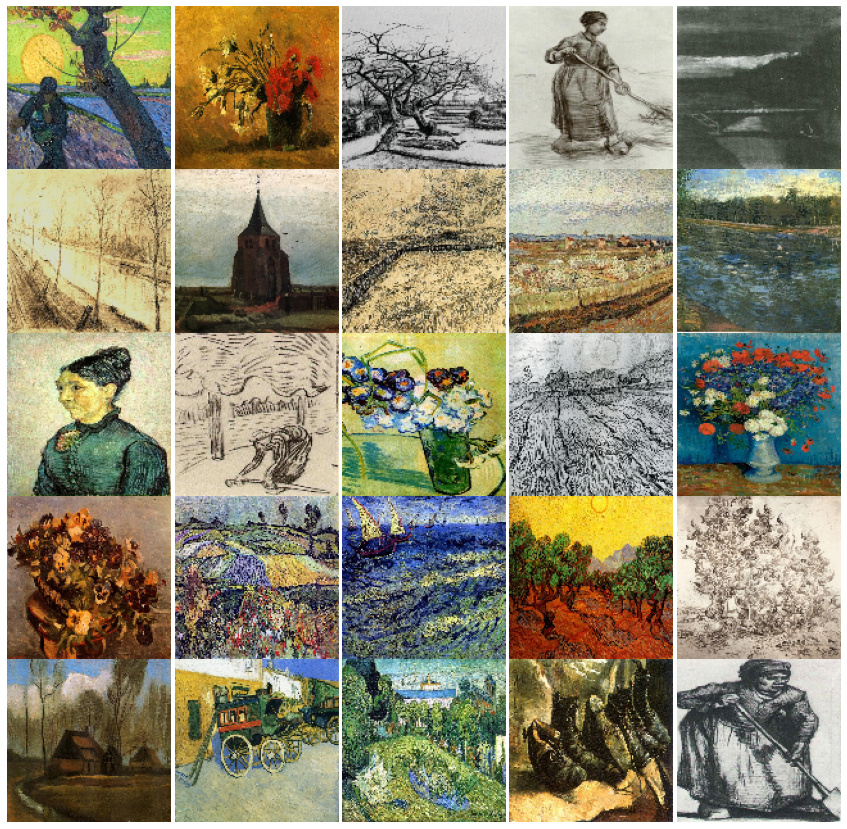

In [4]:
plotImages("Vincent van Gogh","../input/best-artworks-of-all-time/images/images/Vincent_van_Gogh/**")      

### Display some paintaings by **Leonardo da Vinci**

Leonardo da Vinci


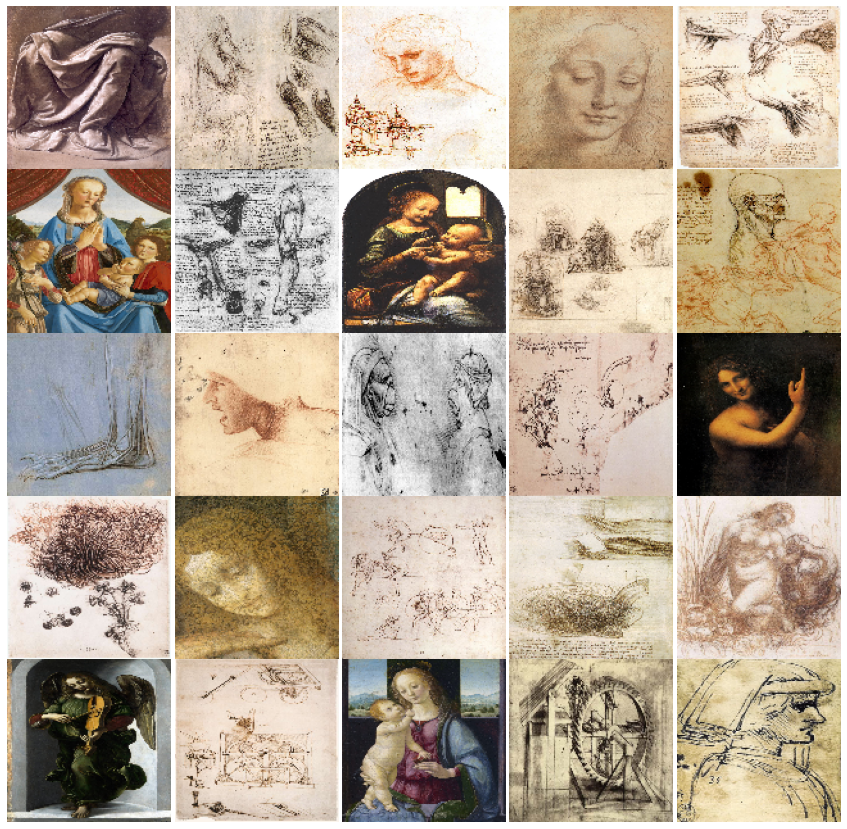

In [5]:
plotImages("Leonardo da Vinci","../input/best-artworks-of-all-time/images/images/Leonardo_da_Vinci/**")      

### Display some paintaings by **Andy Warhol**

Andy Warhol


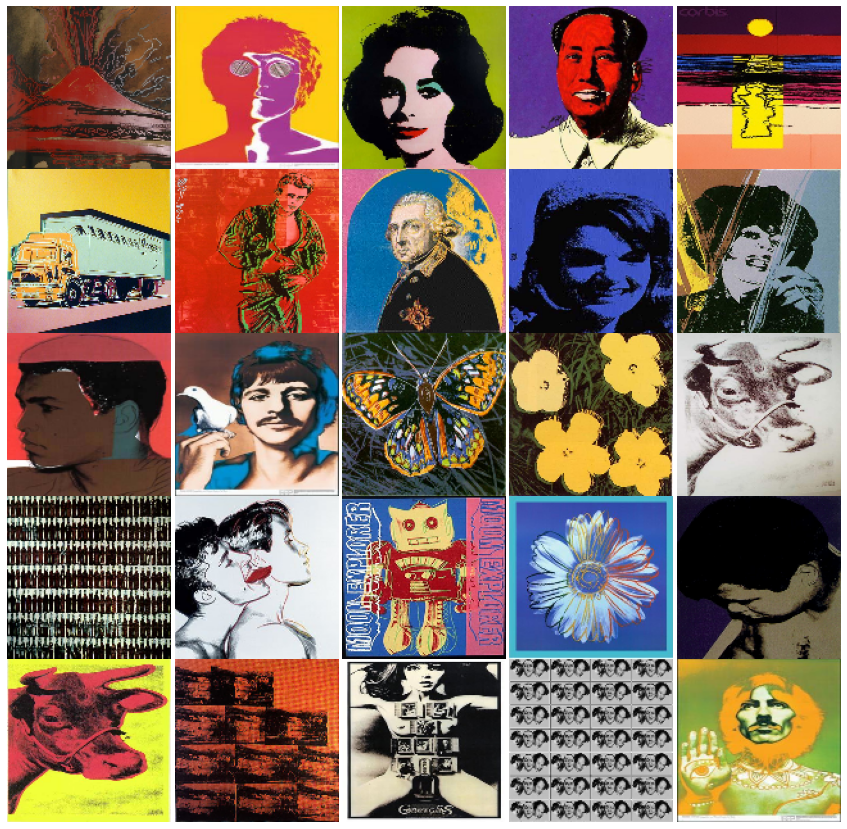

In [6]:
plotImages("Andy Warhol","../input/best-artworks-of-all-time/images/images/Andy_Warhol/**")      

### Load the CSV data

In [7]:
artists = pd.read_csv('../input/best-artworks-of-all-time/artists.csv')

In [8]:
artists

id                       name        years  \
0    0          Amedeo Modigliani  1884 - 1920   
1    1         Vasiliy Kandinskiy  1866 - 1944   
2    2               Diego Rivera  1886 - 1957   
3    3               Claude Monet  1840 - 1926   
4    4              Rene Magritte  1898 - 1967   
5    5              Salvador Dali  1904 - 1989   
6    6              Edouard Manet  1832 - 1883   
7    7              Andrei Rublev  1360 - 1430   
8    8           Vincent van Gogh  1853 – 1890   
9    9               Gustav Klimt  1862 - 1918   
10  10           Hieronymus Bosch  1450 - 1516   
11  11           Kazimir Malevich  1879 - 1935   
12  12             Mikhail Vrubel  1856 - 1910   
13  13              Pablo Picasso  1881 - 1973   
14  14          Peter Paul Rubens  1577 - 1640   
15  15      Pierre-Auguste Renoir  1841 - 1919   
16  16             Francisco Goya  1746 - 1828   
17  17                Frida Kahlo  1907 - 1954   
18  18                   El Greco  1541 - 1614   
19  19             Albrecht Dürer  1471 - 1528   
20  20              Alfred Sisley  1839 - 1899   
21  21             Pieter Bruegel  1525 - 1569   
22  22               Marc Chagall  1887 - 1985   
23  23          Giotto di Bondone  1266 - 1337   
24  24          Sandro Botticelli  1445 - 1510   
25  25                 Caravaggio  1571 - 1610   
26  26          Leonardo da Vinci  1452 - 1519   
27  27            Diego Velazquez  1599 - 1660   
28  28              Henri Matisse  1869 - 1954   
29  29               Jan van Eyck  1395 - 1441   
30  30                Edgar Degas  1834 - 1917   
31  31                  Rembrandt  1606 - 1669   
32  32                     Titian  1488 - 1576   
33  33  Henri de Toulouse-Lautrec  1864 – 1901   
34  34            Gustave Courbet  1819 - 1877   
35  35           Camille Pissarro  1830 - 1903   
36  36             William Turner  1775 - 1851   
37  37               Edvard Munch  1863 - 1944   
38  38               Paul Cezanne  1839 – 1906   
39  39           Eugene Delacroix  1798 – 1863   
40  40             Henri Rousseau  1844 – 1910   
41  41             Georges Seurat  1859 – 1891   
42  42                  Paul Klee  1879 – 1940   
43  43              Piet Mondrian  1872 – 1944   
44  44                  Joan Miro  1893 – 1983   
45  45                Andy Warhol  1928 – 1987   
46  46               Paul Gauguin  1848 – 1903   
47  47                    Raphael  1483 – 1520   
48  48               Michelangelo  1475 – 1564   
49  49            Jackson Pollock  1912 – 1956   

                                      genre               nationality  \
0                             Expressionism                   Italian   
1              Expressionism,Abstractionism                   Russian   
2                   Social Realism,Muralism                   Mexican   
3                             Impressionism                    French   
4                  Surrealism,Impressionism                   Belgian   
5                                Surrealism                   Spanish   
6                     Realism,Impressionism                    French   
7                             Byzantine Art                   Russian   
8                        Post-Impressionism                     Dutch   
9                     Symbolism,Art Nouveau                  Austrian   
10                     Northern Renaissance                     Dutch   
11                              Suprematism                   Russian   
12                                Symbolism                   Russian   
13                                   Cubism                   Spanish   
14                                  Baroque                   Flemish   
15                            Impressionism                    French   
16                              Romanticism                   Spanish   
17                   Primitivism,Surrealism                   Mexican   
18                                Mannerism             Spanish,Gr

In [9]:
artists.shape

(50, 8)

Let us do some data exploration
### Plot paintings by nationality of the painter. 

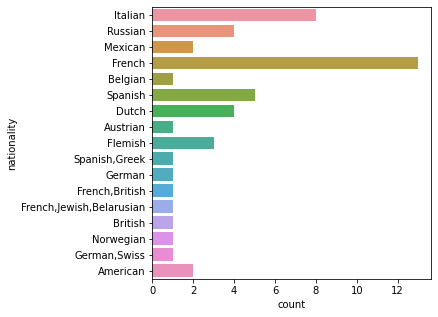

In [10]:
plt.figure(figsize=(5,5))
nationalityPlot = sns.countplot(y='nationality',data=artists)
nationalityPlot

### Plot artists and count of paintings

[]

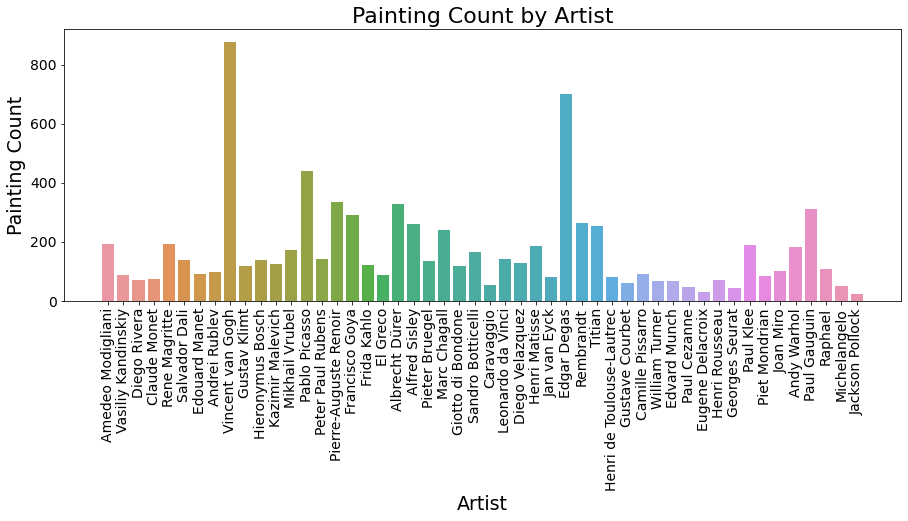

In [11]:
figsize=(15, 5)
ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

col1 = "name"
col2 = "paintings"

sns.barplot(x=col1, y=col2, data=artists)
plt.title("Painting Count by Artist")
plt.xlabel("Artist")
plt.ylabel("Painting Count")
plt.xticks(rotation=90)
plt.plot()

### Create dataframe with artists having min of 200 paintings.

Here I have first sorted data according to feature painting so that all my data in sorted manner and according to their painting name. I have taken paintings >200 for our analysis just taken sample data.


I have also added one more feature in this called ‘class_weight’ which put weight on paintings why we want weight actually simple putting weight on something it tells us the importance of that particular thing right.

In [12]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]

artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

name  paintings  class_weight
0        Vincent van Gogh        877      0.445631
1             Edgar Degas        702      0.556721
2           Pablo Picasso        439      0.890246
3   Pierre-Auguste Renoir        336      1.163149
4          Albrecht Dürer        328      1.191519
5            Paul Gauguin        311      1.256650
6          Francisco Goya        291      1.343018
7               Rembrandt        262      1.491672
8           Alfred Sisley        259      1.508951
9                  Titian        255      1.532620
10           Marc Chagall        239      1.635223

Create a key value pairs of class index and weights

In [13]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [14]:
# There is some problem recognizing 'Albrecht_Dürer' (don't know why, worth exploring)
# So I'll update this string as directory name to df's
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [15]:
# Explore images of top artists
images_dir = '../input/best-artworks-of-all-time/images/images/'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> ../input/best-artworks-of-all-time/images/images/Vincent_van_Gogh
Found --> ../input/best-artworks-of-all-time/images/images/Edgar_Degas
Found --> ../input/best-artworks-of-all-time/images/images/Pablo_Picasso
Found --> ../input/best-artworks-of-all-time/images/images/Pierre-Auguste_Renoir
Found --> ../input/best-artworks-of-all-time/images/images/Albrecht_Dürer
Found --> ../input/best-artworks-of-all-time/images/images/Paul_Gauguin
Found --> ../input/best-artworks-of-all-time/images/images/Francisco_Goya
Found --> ../input/best-artworks-of-all-time/images/images/Rembrandt
Found --> ../input/best-artworks-of-all-time/images/images/Alfred_Sisley
Found --> ../input/best-artworks-of-all-time/images/images/Titian
Found --> ../input/best-artworks-of-all-time/images/images/Marc_Chagall


### Print few random paintings along with artists name

Lets display some random paintings for clear visualization whats happening right.

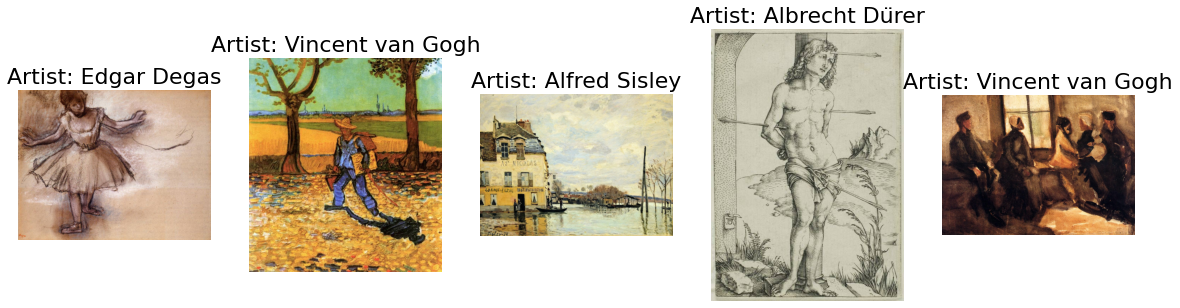

In [16]:
# Print few random paintings
import random
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

### Data Augmentation


Data Augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. This technique like padding , cropping , shifting , flipping etc.

**ImageDataGenerator()** the ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data.

In [17]:
batch_size = 64
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.
Total number of batches = 53 and 13


### Build Model


So here in this part we are going to build model which train our data as previously I have mentioned that I will use state of the art technique like **ResNet50** model. I can use CNN(Convolutional Neural Network) but when I read the research paper that **ResNet50** network does a tremendous job on image data so let’s begin this section.

**ResNet50** model is also called identity layer why because the sole purpose of identity layer is skip-connection that means skip one layer in ResNet model which helps reducing vanishing gradient problem 

The ResNet model is adapted to the 1000 categories of ImageNet. Our task, however, is to classify some artists.

What can we do? With keras, it's easy to import only the convolutional part of VGG16, by setting the include_top parameter to False :

In [18]:
# Load pre-trained model
from keras.applications import *
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

94773248/94765736 [==============================] - 1s 0us/step


In [28]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

conv4_block6_add (Add)          (None, 14, 14, 1024) 0           conv4_block5_out[0][0]           
                                                                 conv4_block6_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block6_out (Activation)   (None, 14, 14, 1024) 0           conv4_block6_add[0][0]           
__________________________________________________________________________________________________
conv5_block1_1_conv (Conv2D)    (None, 7, 7, 512)    524800      conv4_block6_out[0][0]           
__________________________________________________________________________________________________
conv5_block1_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block1_1_relu (Activation (None, 7, 7, 512)    0           conv5_block1_1_bn[0][0]          
__________

ImageNet is an image database organized according to the WordNet hierarchy this is freely available for researcher and data scientist for research purposes.

### Create your Convolutional Neural Network

In [19]:
classifier = Flatten()(base_model.output)

#Initialize the CNN
classifier = Dense(512, activation='relu')(classifier)
classifier = BatchNormalization()(classifier)

classifier= Dense(16, activation='relu')(classifier)
classifier = BatchNormalization()(classifier)

output = Dense(n_classes, activation = 'softmax')(classifier)

In [20]:
model = Model(inputs=base_model.input, outputs=output)

### Compile the CNN

In [21]:
#Compile the CNN
model.compile(optimizer = Adam(lr =0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Train Model


In [22]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [24]:
history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/10
53/53 [==============================] - 128s 2s/step - loss: 1.0776 - accuracy: 0.6722 - val_loss: 3.8131 - val_accuracy: 0.0673
Epoch 2/10
53/53 [==============================] - 124s 2s/step - loss: 0.7685 - accuracy: 0.8124 - val_loss: 3.4128 - val_accuracy: 0.0625
Epoch 3/10
53/53 [==============================] - 124s 2s/step - loss: 0.6170 - accuracy: 0.8799 - val_loss: 2.7277 - val_accuracy: 0.0649
Epoch 4/10
53/53 [==============================] - 126s 2s/step - loss: 0.5008 - accuracy: 0.9180 - val_loss: 3.7145 - val_accuracy: 0.0841
Epoch 5/10
53/53 [==============================] - 121s 2s/step - loss: 0.4081 - accuracy: 0.9488 - val_loss: 3.8592 - val_accuracy: 0.0589
Epoch 6/10
53/53 [==============================] - 121s 2s/step - loss: 0.3470 - accuracy: 0.9598 - val_loss: 3.9077 - val_accuracy: 0.0529
Epoch 7/10
53/53 [==============================] - 122s 2s/step - loss: 0.3033 - accuracy: 0.9683 - val_loss: 3.3106 - val_accuracy: 0.0601
Epoch 8/10
53

Here is the result after training the model for first time accuracy touched by my model is 0.98 or (98%) and loss reduce from 1.07 to 0.21 means model doing good now we freeze layers and re-train again.

### Fine tuning the model

Freezing a layer prevents its weights from being modified. This technique is often used in transfer learning, where the base model(trained on some other dataset)is frozen indicating that this layer should not be trained

In [27]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 50
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/50
53/53 [==============================] - 126s 2s/step - loss: 0.1636 - accuracy: 0.9944 - val_loss: 2.8097 - val_accuracy: 0.1442
Epoch 2/50
53/53 [==============================] - 120s 2s/step - loss: 0.1363 - accuracy: 0.9941 - val_loss: 2.6698 - val_accuracy: 0.1659
Epoch 3/50
53/53 [==============================] - 122s 2s/step - loss: 0.1240 - accuracy: 0.9926 - val_loss: 2.5169 - val_accuracy: 0.2091
Epoch 4/50
53/53 [==============================] - 119s 2s/step - loss: 0.1065 - accuracy: 0.9914 - val_loss: 2.6633 - val_accuracy: 0.2236
Epoch 5/50
53/53 [==============================] - 122s 2s/step - loss: 0.1006 - accuracy: 0.9935 - val_loss: 2.6904 - val_accuracy: 0.2488
Epoch 6/50
53/53 [==============================] - 121s 2s/step - loss: 0.0894 - accuracy: 0.9938 - val_loss: 2.5666 - val_accuracy: 0.3005
Epoch 7/50
53/53 [==============================] - 121s 2s/step - loss: 0.0869 - accuracy: 0.9917 - val_loss: 2.6742 - val_accuracy: 0.3089
Epoch 8/50
53

Text(0.5, 1.0, 'Train - Accuracy')

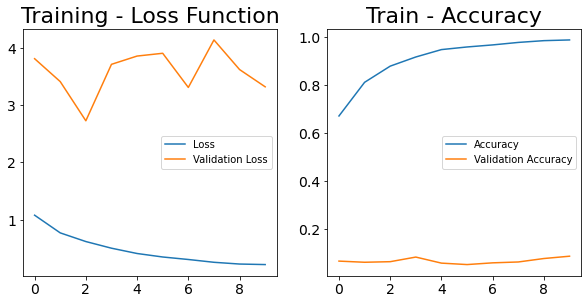

In [29]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [30]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

54/54 [==============================] - 117s 2s/step - loss: 0.0323 - accuracy: 0.9991
Prediction accuracy on train data = 0.9991289377212524


In [35]:
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on test data =", score[1])

14/14 [==============================] - 26s 2s/step - loss: 0.4311 - accuracy: 0.8702
Prediction accuracy on test data = 0.8701754212379456


### print classification report

In [ ]:
#Get the predictions for the test data
predicted_classes = cnn_model.predict_classes(x_test)

#Get the indices to be plotted
y_true = test_df.iloc[:, 0]

from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

### Test Model

Here taking randomly 5 images and giving this random images to model to predict the artist by giving 5 random images that belong to particular artist or not.

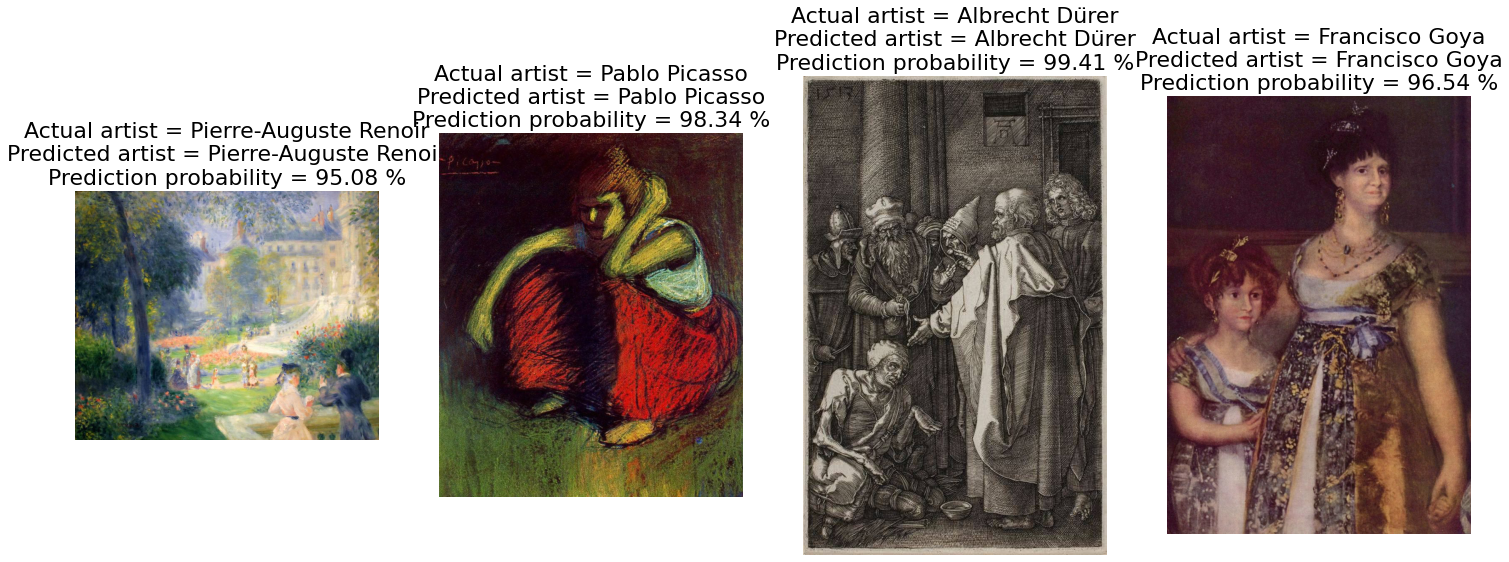

In [37]:
# Prediction
from keras.preprocessing import *

n = 4
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

So, from above we could see that given 4 random images our model predicted right artist name with given image on average probability of around 87% and above.